### Data Processing

In [2]:
from define_classes import *
from data_processing import *
from pca import *
from csv_clean import *
from polynomial_regression import *
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Setting the number of classes for different wine quality points threshold

In [4]:
data = pd.read_csv('data.csv', index_col=0)
print('Possible thresdholds for classification:',np.sort(data['quality'].unique()))

Possible thresdholds for classification: [3 4 5 6 7 8 9]


In [5]:
target = 'cat'
n_c = 4 # bad, average, good wine
thres = [4,6,7]
value = 'quality'

import define_classes
# self,data:pd.DataFrame, target, n_c, thres: list or int, value
dt = define_classes.DefineTarget(data)
# self, target, n_c, thres: list or int, value
data = dt.get_classes(target, n_c, thres, value)

In [6]:
data['cat'].value_counts()

1    4974
2    1079
0     246
3     198
Name: cat, dtype: int64

# Client Features Selection

In [10]:
data.loc[data['cat']==1].describe()

,fixedacidity,volatileacidity,citricacid,residualsugar,chlorides,freesulfurdioxide,totalsulfurdioxide,density,pH,sulphates,alcohol,quality,type,cat
count,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.000000,4974.0
mean,7.241536,0.346423,0.316765,5.659087,0.058674,30.766285,117.744069,0.995113,3.215346,0.529908,10.265275,5.570165,0.265179,1.0
std,1.279894,0.165660,0.150658,4.935219,0.036437,17.604133,57.861460,0.002867,0.159461,0.144591,1.070626,0.495102,0.441473,0.0
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987220,2.720000,0.230000,8.000000,5.000000,0.000000,1.0
25%,6.400000,0.230000,0.240000,1.800000,0.040000,17.000000,76.000000,0.992992,3.110000,0.440000,9.400000,5.000000,0.000000,1.0
50%,7.000000,0.300000,0.310000,3.100000,0.049000,29.000000,121.000000,0.995400,3.200000,0.510000,10.000000,6.000000,0.000000,1.0
75%,7.700000,0.420000,0.400000,8.500000,0.070000,42.000000,160.000000,0.997200,3.320000,0.600000,11.000000,6.000000,1.000000,1.0
max,15.900000,1.330000,1.660000,65.800000,0.611000,131.000000,344.000000,1.038980,4.010000,1.980000,14.900000,6.000000,1.000000,1.0


Since our client doesn't gather the same data as contained in our innitial sample, to train the model we will include only the information that is available for the company

In [11]:
client_data = ['alcohol', 'fixedacidity', 'pH', 'volatileacidity', 'freesulfurdioxide', 'totalsulfurdioxide', 
               'type', 'cat', 'quality']

In [12]:
# rewrite csv with the target variable
data = data[client_data]
data.to_csv('data_client_four.csv')

#### We can see a large inbalance in the very good(class 3) and bad wines (class 0)

In [13]:
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import recall_score, classification_report, accuracy_score, precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
from ordinal import *
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn import metrics
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [14]:
# Splitting Data

csv = 'data_client_four.csv'
y = 'cat'
d = DataClean(csv)
df_mm, num_scale = d.read_scale(csv)
X_train, X_test, y_train, y_test = d.split(csv, y)

### Balancing the Classes : SMOTE

In [15]:
smt = SMOTE(sampling_strategy='not majority', k_neighbors=3)
X_train_s, y_train_s = smt.fit_sample(np.asarray(X_train), np.asarray(y_train))

col = list(num_scale.columns)

X_train_smote = pd.DataFrame(X_train_s, columns=col)
y_train_smote = pd.DataFrame(y_train_s, columns=['cat'])

smote_df = X_train_smote.join(y_train_smote)

smote_df.groupby('cat').count().iloc[:,0]

cat
0    3982
1    3982
2    3982
3    3982
Name: alcohol, dtype: int64

### Ordinal Classification 

Ordinal variables are those whose value exists on an arbitrary scale where only the relative ordering between different values is significant. In our case 0 to 3 is the order definining the incremental quality of wine. Therefore the estimation should take into account that our variables are 'order-dependent'.    
A way to tackle this type of classes (ordered) is using the 'OrdinalClassifier' class available for python in GitHub. This will create binary vectors for each class. This can be applied to classifiers that generate classes probability, or in python what we know as 'predict_proba'

In [16]:
y_train_bin = label_binarize(y_train_smote, classes=[0, 1, 2])

In [17]:
clf = OrdinalClassifier(LogisticRegression(C =1e9 ,solver='newton-cg',fit_intercept=True, multi_class='multinomial'))

In [18]:
clf.fit(X_train_smote, y_train_smote)

In [19]:
lr_prob = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.69      0.22        55
           1       0.89      0.41      0.56       992
           2       0.27      0.41      0.33       211
           3       0.11      0.60      0.19        42

    accuracy                           0.43      1300
   macro avg       0.35      0.53      0.32      1300
weighted avg       0.73      0.43      0.50      1300



### Results: 
 - High precission for only the average wine class. High recall on the classes with low precision

## Voting Classifier

In [20]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1, class_weight='balanced')
clf2 = RandomForestClassifier(n_estimators=50, random_state=1, class_weight='balanced' )
clf3 = GaussianNB()
clf4 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
clf5 = SVC(kernel="linear", class_weight="balanced", C=1.0, decision_function_shape = 'ovo')
clf6 = DecisionTreeClassifier()

In [21]:
eclf1 = VotingClassifier(estimators=[ ('lr', clf1), ('rf', clf2), ('gnb', clf3), ('knn', clf4), ('svc', clf5)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
y_vt = eclf1.predict(X_test)

In [22]:
y_vot = eclf1.score(X_test, y_test)

In [23]:
print(classification_report(y_test, y_vt))

              precision    recall  f1-score   support

           0       0.24      0.15      0.18        55
           1       0.83      0.89      0.86       992
           2       0.50      0.42      0.45       211
           3       0.50      0.24      0.32        42

    accuracy                           0.76      1300
   macro avg       0.52      0.42      0.45      1300
weighted avg       0.74      0.76      0.75      1300



Text(0.5, 352.48, 'Predicted label')

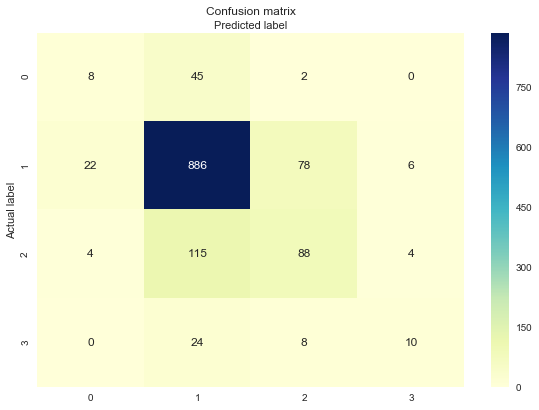

In [24]:
cnf_matrix = metrics.confusion_matrix(y_test, y_vt)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Pipeline and GridSearchCV

In [25]:
models = [('clf', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('knn', KNeighborsClassifier()),
        ('svm', SVC()),
        ('lg', LogisticRegression())]


spaces = [[{"clf": [DecisionTreeClassifier()],
                    "clf__criterion": ['gini', 'entropy'],
                    "clf__presort": [True, False]}],
                [{"rf": [RandomForestClassifier()],
                    "rf__n_estimators": [10, 100, 1000],
                    "rf__max_features": [1, 2, 3],
                    'rf__max_features': ['auto', 'sqrt', 'log2']}],
                [{ "knn" : [KNeighborsClassifier()],
                    'knn__n_neighbors': [1,2,3,4,5,6,7,8,9],
                    'knn__p': [1,2]}],
                [{"svm" : [SVC()],
                    'svm__kernel': ['linear','rbf', 'sigmoid'],
                    'svm__decision_function_shape': ['ovo', 'ovr']}],
                [{ "lg" : [LogisticRegression()],
                    "lg__penalty": ['l1', 'l2'],
                    "lg__C": np.logspace(0, 4, 10)}]]


g_p = []
b_e = []
y_pred_p = []

for m, s in zip(models,spaces):
    pipeline = Pipeline([m])
    pipeline.fit(X_train_smote, y_train_smote) # doctest: +ELLIPSIS
    y_hat = pipeline.predict(X_test)
    print(m[0],classification_report(y_test, y_hat))
    classifier = GridSearchCV(pipeline, s, cv=5, verbose=0).fit(X_train_smote, y_train_smote)
    y_hat = classifier.predict(X_test)
    y_pred_p.append(y_hat)
    bp = classifier.best_estimator_
    gp = classifier.get_params()
    b_e.append(bp)
    g_p.append(gp)

clf               precision    recall  f1-score   support

           0       0.18      0.29      0.22        55
           1       0.89      0.79      0.84       992
           2       0.52      0.63      0.57       211
           3       0.27      0.45      0.34        42

    accuracy                           0.73      1300
   macro avg       0.47      0.54      0.49      1300
weighted avg       0.78      0.73      0.75      1300

rf               precision    recall  f1-score   support

           0       0.24      0.25      0.25        55
           1       0.88      0.84      0.86       992
           2       0.54      0.61      0.57       211
           3       0.37      0.52      0.44        42

    accuracy                           0.77      1300
   macro avg       0.51      0.56      0.53      1300
weighted avg       0.78      0.77      0.78      1300

knn               precision    recall  f1-score   support

           0       0.12      0.29      0.17        55
          

 ### Results:
 
  - RandomForest seems to perform the best for the three classes
 

In [26]:
print(models[1][0])
print('_______________________________')
print('best parameters:', b_e[1])


rf
_______________________________
best parameters: Pipeline(memory=None,
         steps=[('rf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)


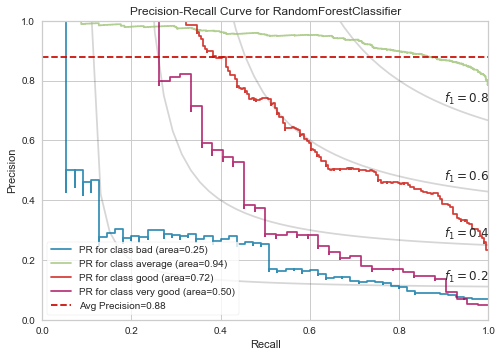

In [29]:
viz = PrecisionRecallCurve(b_e[1], 
                    per_class=True, iso_f1_curves=True,
                    fill_area=False, micro=False, classes=['bad','average','good','very good']
                )

viz.fit(X_train_smote, y_train_smote)
viz.score(X_test, y_test)
viz.show()

Text(0.5, 352.48, 'Predicted label')

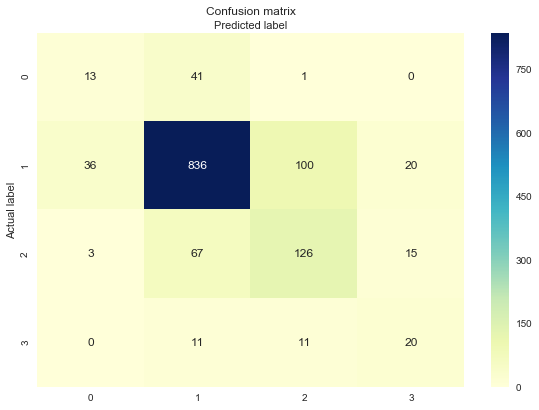

In [27]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_p[1])
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Feature Importance

In [ ]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)
model.fit(X_train_smote, y_train_smote)

In [ ]:
y_pred = model.predict(X_test)

importances = model.feature_importances_

dt_feature_importance = [(X_train_smote.columns[i[0]], i[1]) for i in list(enumerate(importances))]
dt_feature_importance = sorted(dt_feature_importance, key = lambda x: x[1], reverse = True)[:5]
fig = plt.figure(figsize = (8,5))
plt.bar([i[0] for i in dt_feature_importance], [i[1] for i in dt_feature_importance], color='skyblue')

### Results: Voting vs Gridsearch
- Pipeline and GridsearchCV shows better predictive results

# Model Performance: PCA - 3 classes

Original number of features: 6
Reduced number of features: 6


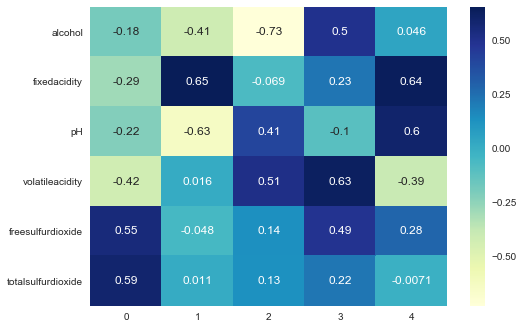

In [39]:
# Running PCA Analysis
csv = 'data_client.csv'
target = 'cat'
p = PcaAnalysis(csv,target)
pca, features_df = p.pca_features(csv,target)
g = p.get_components(csv,target,5)

# join pca components to dataframe and save on csv

pca_df = features_df.join(data['cat'])
data.reset_index(drop=True,inplace=True)
pca_df = features_df.join(data['cat'])
pca_df.to_csv('pca_3.csv')

In [42]:
# Splitting Data
csv = 'pca_3.csv'
y = 'cat'
d = DataClean(csv)
df_mm, num_scale = d.read_scale(csv)
X_train, X_test, y_train, y_test = d.split(csv,y)

In [43]:
df_mm.groupby('cat').count().iloc[:,0]

cat
0     246
1    4974
2    1277
Name: c0, dtype: int64

### Rebalancing Classes

In [44]:
smt = SMOTE(sampling_strategy='not majority', k_neighbors=3)
X_train_s, y_train_s = smt.fit_sample(np.asarray(X_train), np.asarray(y_train))

col = list(num_scale.columns)

X_train_p = pd.DataFrame(X_train_s, columns=col)
y_train_p= pd.DataFrame(y_train_s, columns=['cat'])

smote_df = X_train_smote.join(y_train_p)

smote_df.groupby('cat').count().iloc[:,0]

cat
0    3982
1    3982
2    3982
Name: alcohol, dtype: int64

In [74]:
models = [('clf', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('knn', KNeighborsClassifier()),
        ('svm', SVC()),
        ('lg', LogisticRegression())]


spaces = [[{"clf": [DecisionTreeClassifier()],
                    "clf__criterion": ['gini', 'entropy'],
                    "clf__presort": [True, False]}],
                [{"rf": [RandomForestClassifier()],
                    "rf__n_estimators": [10, 100, 1000],
                    "rf__max_features": [1, 2, 3],
                    'rf__max_features': ['auto', 'sqrt', 'log2']}],
                [{ "knn" : [KNeighborsClassifier()],
                    'knn__n_neighbors': [1,2,3,4,5,6,7,8,9],
                    'knn__p': [1,2]}],
                [{"svm" : [SVC()],
                    'svm__kernel': ['linear','rbf', 'sigmoid'],
                    'svm__decision_function_shape': ['ovo', 'ovr']}],
                [{ "lg" : [LogisticRegression()],
                    "lg__penalty": ['l1', 'l2'],
                    "lg__C": np.logspace(0, 4, 10)}]]


g_p = []
b_e = []
y_pred_p = []

for m, s in zip(models,spaces):
    pipeline = Pipeline([m])
    pipeline.fit(X_train_p, y_train_p) 
    y_hat = pipeline.predict(X_test)
    print(m[0],classification_report(y_test, y_hat))
    classifier = GridSearchCV(pipeline, s, cv=5, verbose=0).fit(X_train_p, y_train_p)
    y_hat = classifier.predict(X_test)
    y_pred_p.append(y_hat)
    bp = classifier.best_estimator_
    gp = classifier.get_params()
    b_e.append(bp)
    g_p.append(gp)

clf               precision    recall  f1-score   support

           0       0.13      0.20      0.16        55
           1       0.87      0.79      0.83       992
           2       0.54      0.68      0.60       253

    accuracy                           0.74      1300
   macro avg       0.51      0.55      0.53      1300
weighted avg       0.77      0.74      0.75      1300

rf               precision    recall  f1-score   support

           0       0.18      0.18      0.18        55
           1       0.89      0.84      0.86       992
           2       0.62      0.73      0.67       253

    accuracy                           0.79      1300
   macro avg       0.56      0.59      0.57      1300
weighted avg       0.80      0.79      0.80      1300

knn               precision    recall  f1-score   support

           0       0.10      0.29      0.15        55
           1       0.89      0.65      0.76       992
           2       0.49      0.81      0.61       253

    accur

### Results:
    - Compared to the previous estimation PCA components does not improve significantly the performance. 
    - Random forest continues to perform the best. Small improvement from non-PCA model
    

### PRECISION-RECALL Curve

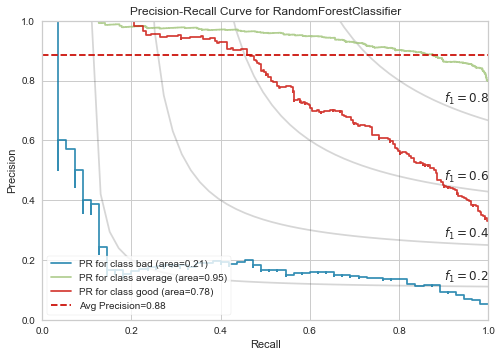

In [76]:
viz = PrecisionRecallCurve(b_e[1], 
                    per_class=True, iso_f1_curves=True,
                    fill_area=False, micro=False, classes=['bad','average','good']
                )

viz.fit(X_train_smote, y_train_smote)
viz.score(X_test, y_test)
viz.show()

## Feature Importance

In [80]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)
model.fit(X_train_p, y_train_p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<BarContainer object of 5 artists>

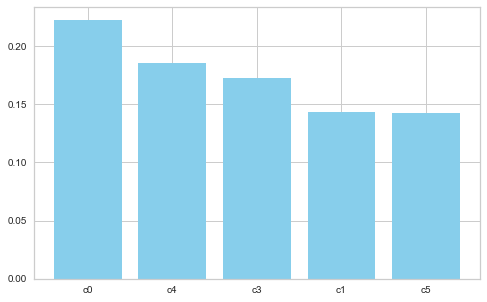

In [45]:
y_pred = model.predict(X_test)

importances = model.feature_importances_

y_pred = model.predict(X_test)

importances = model.feature_importances_

dt_feature_importance = [(X_train_p.columns[i[0]], i[1]) for i in list(enumerate(importances))]
dt_feature_importance = sorted(dt_feature_importance, key = lambda x: x[1], reverse = True)[:5]
fig = plt.figure(figsize = (8,5))
plt.bar([i[0] for i in dt_feature_importance], [i[1] for i in dt_feature_importance], color='skyblue')